In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
activity_cols = ['IN_VEHICLE', 'ON_BIKE', 'ON_FOOT', 'RUNNING', 'STILL', 'WALKING']
mood_cols = ['Q1_SAD', 'Q2_HAPP', 'Q3_FATIG', 'Q4_EN', 'Q5_REL']

In [3]:
feature_sets = {
    'activity_based': [
        'IN_VEHICLE_prop', 'ON_BIKE_prop', 'ON_FOOT_prop',
        'RUNNING_prop', 'STILL_prop', 'WALKING_prop',
        'IN_VEHICLE_rate', 'ON_BIKE_rate', 'ON_FOOT_rate',
        'RUNNING_rate', 'STILL_rate', 'WALKING_rate'
    ],
    
    'phone_usage': [
        'daily_screen_hours', 'avg_session_duration',
        'usage_per_day_hours', 'UNLOCK_EVENTS_NUM'
    ],
    
    'physical_activity': [
        'activity_intensity', 'activity_intensity_ma7',
        'activity_intensity_std7'
    ],
    
    'sleep': [
        'sleep_hours', 'sleep_hours_ma7'
    ],
    
    'temporal': [
        'dayofweek', 'is_weekend', 'month'
    ]
}

Processing afflictedrevenueepilepsy_daily_metrics.csv...

Activity Counts Summary:
       IN_VEHICLE     ON_BIKE     ON_FOOT  RUNNING        STILL  WALKING
count  370.000000  370.000000  370.000000    370.0   370.000000    370.0
mean    49.389189    1.370270   25.635135      0.0   680.124324      0.0
std     33.800946    3.549218   19.627544      0.0   444.074948      0.0
min      0.000000    0.000000    0.000000      0.0    33.000000      0.0
25%     21.000000    0.000000    9.000000      0.0   197.250000      0.0
50%     52.500000    0.000000   22.000000      0.0   630.000000      0.0
75%     74.000000    1.000000   37.000000      0.0  1128.500000      0.0
max    169.000000   25.000000   92.000000      0.0  1415.000000      0.0

Mood Statistics:
           Q1_SAD     Q2_HAPP    Q3_FATIG       Q4_EN      Q5_REL
count  360.000000  360.000000  360.000000  360.000000  360.000000
mean     1.463321    1.653654    2.248440    1.668935    2.048798
std      0.827290    0.942208    0.853813   

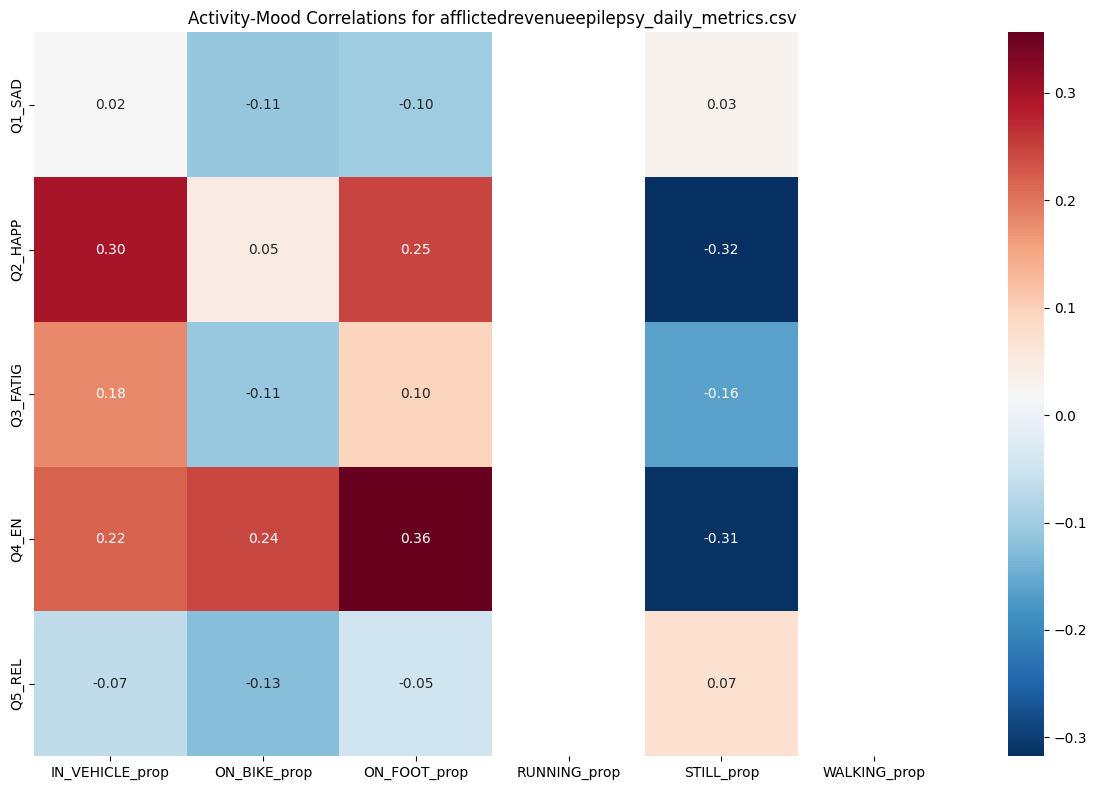

Processing anagramprobingscrooge_daily_metrics.csv...

Activity Counts Summary:
       IN_VEHICLE     ON_BIKE     ON_FOOT  RUNNING       STILL  WALKING
count  371.000000  371.000000  371.000000    371.0  371.000000    371.0
mean     8.528302    0.452830   43.250674      0.0  184.107817      0.0
std     14.798507    1.124571   34.777660      0.0   67.446469      0.0
min      0.000000    0.000000    0.000000      0.0   11.000000      0.0
25%      0.000000    0.000000   10.000000      0.0  143.000000      0.0
50%      1.000000    0.000000   42.000000      0.0  176.000000      0.0
75%     11.000000    1.000000   62.000000      0.0  214.500000      0.0
max     88.000000   10.000000  167.000000      0.0  492.000000      0.0

Mood Statistics:
           Q1_SAD     Q2_HAPP    Q3_FATIG       Q4_EN      Q5_REL
count  365.000000  365.000000  365.000000  365.000000  365.000000
mean     2.572031    3.113219    2.686852    3.063329    3.640014
std      0.751725    0.713809    0.808844    0.771687   

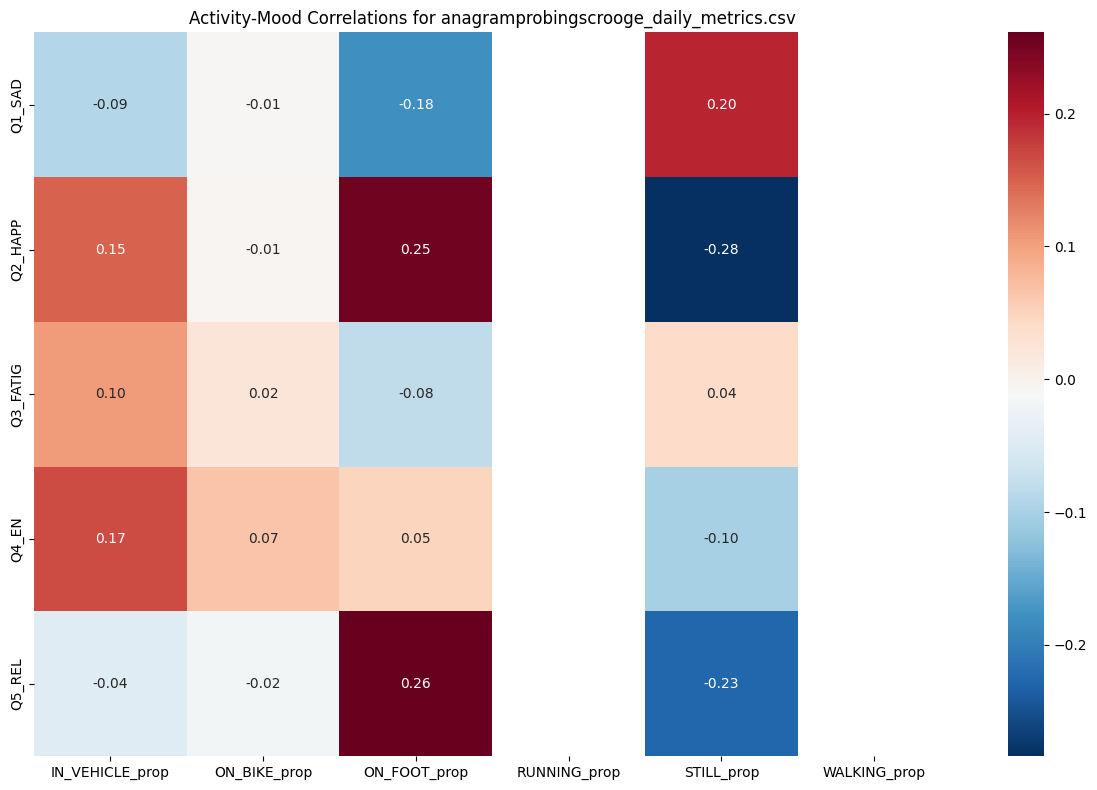

Processing diagramuncoupleoutput_daily_metrics.csv...

Activity Counts Summary:
       IN_VEHICLE     ON_BIKE     ON_FOOT  RUNNING        STILL  WALKING
count  328.000000  328.000000  328.000000    328.0   328.000000    328.0
mean    23.893293    0.307927   34.713415      0.0   470.646341      0.0
std     43.736187    0.707970   27.704042      0.0   350.909325      0.0
min      0.000000    0.000000    0.000000      0.0     1.000000      0.0
25%      0.000000    0.000000   13.750000      0.0   247.000000      0.0
50%      4.500000    0.000000   25.000000      0.0   301.500000      0.0
75%     34.000000    0.000000   48.000000      0.0   554.000000      0.0
max    365.000000    5.000000  175.000000      0.0  1325.000000      0.0

Mood Statistics:
           Q1_SAD     Q2_HAPP    Q3_FATIG       Q4_EN      Q5_REL
count  320.000000  320.000000  320.000000  320.000000  320.000000
mean     2.241080    2.616465    2.481222    1.883339    3.269159
std      0.902399    0.772737    0.871683    0.

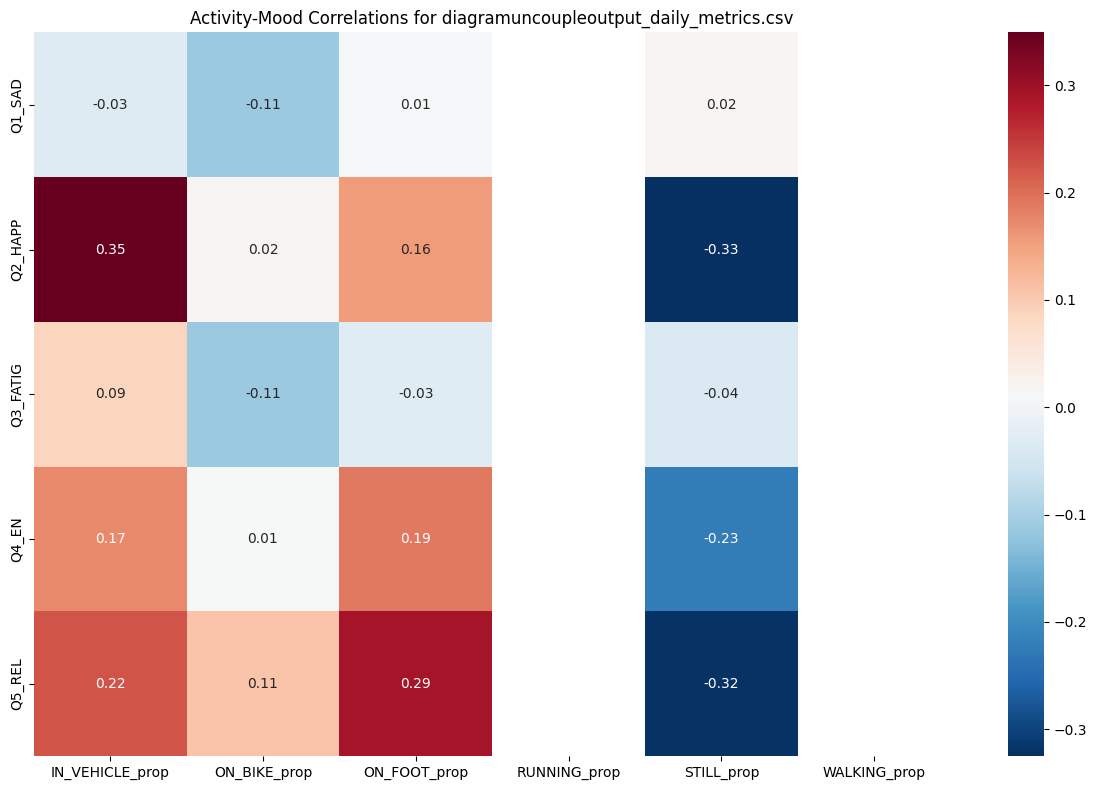

Processing equallustinessuntil_daily_metrics.csv...

Activity Counts Summary:
       IN_VEHICLE     ON_BIKE     ON_FOOT  RUNNING       STILL  WALKING
count  331.000000  331.000000  331.000000    331.0  331.000000    331.0
mean   129.389728    0.429003    6.042296      0.0  136.728097      0.0
std    157.182414    2.183326   10.698826      0.0   86.639859      0.0
min      0.000000    0.000000    0.000000      0.0    1.000000      0.0
25%     13.500000    0.000000    1.000000      0.0   85.000000      0.0
50%     54.000000    0.000000    2.000000      0.0  122.000000      0.0
75%    225.000000    0.000000    6.000000      0.0  162.500000      0.0
max    578.000000   23.000000   77.000000      0.0  462.000000      0.0

Mood Statistics:
           Q1_SAD     Q2_HAPP    Q3_FATIG       Q4_EN      Q5_REL
count  305.000000  305.000000  305.000000  305.000000  305.000000
mean     2.054206    3.043094    2.354846    2.950036    3.036396
std      0.260467    0.252631    0.515737    0.317350    0

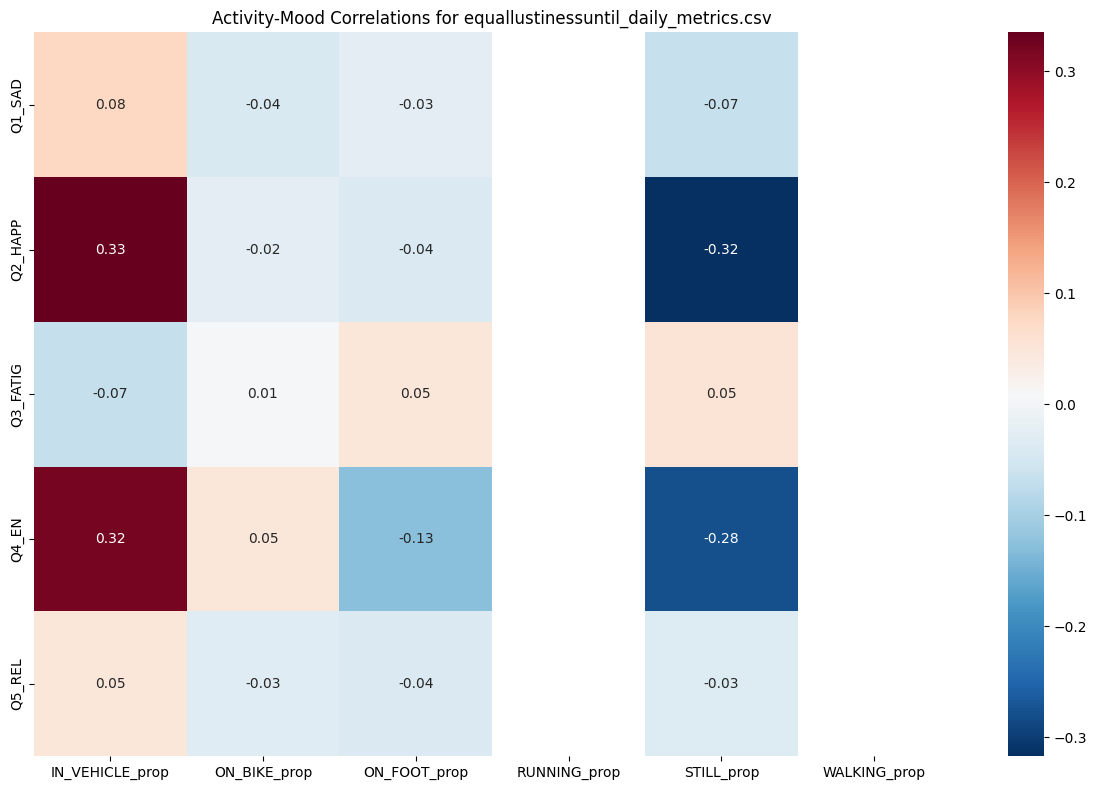

Processing genderradiantlycharging_daily_metrics.csv...

Activity Counts Summary:
       IN_VEHICLE     ON_BIKE     ON_FOOT  RUNNING        STILL  WALKING
count  323.000000  323.000000  323.000000    323.0   323.000000    323.0
mean    35.473684    0.340557   12.328173      0.0   792.510836      0.0
std     29.648695    0.585908    9.725617      0.0   504.353669      0.0
min      0.000000    0.000000    0.000000      0.0    27.000000      0.0
25%     17.000000    0.000000    6.000000      0.0   159.000000      0.0
50%     34.000000    0.000000   10.000000      0.0  1111.000000      0.0
75%     46.000000    1.000000   15.000000      0.0  1237.500000      0.0
max    278.000000    3.000000   69.000000      0.0  1377.000000      0.0

Mood Statistics:
           Q1_SAD     Q2_HAPP    Q3_FATIG       Q4_EN      Q5_REL
count  353.000000  354.000000  354.000000  354.000000  354.000000
mean     1.389663    3.126054    1.726694    3.057313    2.313663
std      0.740925    0.953994    0.870247    

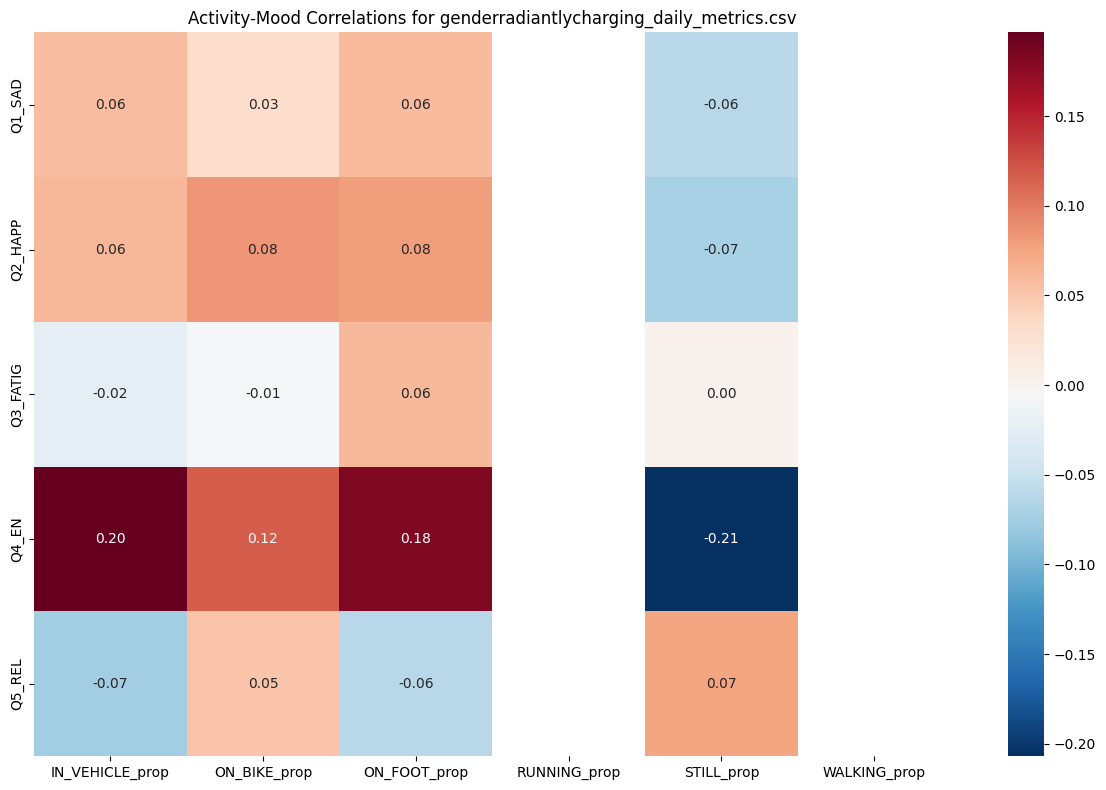

Processing idealistsustainerexpansive_daily_metrics.csv...

Activity Counts Summary:
       IN_VEHICLE     ON_BIKE     ON_FOOT  RUNNING        STILL  WALKING
count  356.000000  356.000000  356.000000    356.0   356.000000    356.0
mean     5.755618    0.073034    4.960674      0.0   470.058989      0.0
std     11.696122    0.309935    9.309914      0.0   520.902158      0.0
min      0.000000    0.000000    0.000000      0.0    19.000000      0.0
25%      0.000000    0.000000    0.000000      0.0    70.000000      0.0
50%      2.000000    0.000000    1.000000      0.0   128.000000      0.0
75%      6.250000    0.000000    6.000000      0.0  1159.250000      0.0
max    116.000000    3.000000   73.000000      0.0  1404.000000      0.0

Mood Statistics:
           Q1_SAD     Q2_HAPP    Q3_FATIG       Q4_EN      Q5_REL
count  362.000000  362.000000  362.000000  362.000000  362.000000
mean     2.777321    1.526855    3.358997    1.085494    1.260457
std      0.732919    0.802495    0.800836 

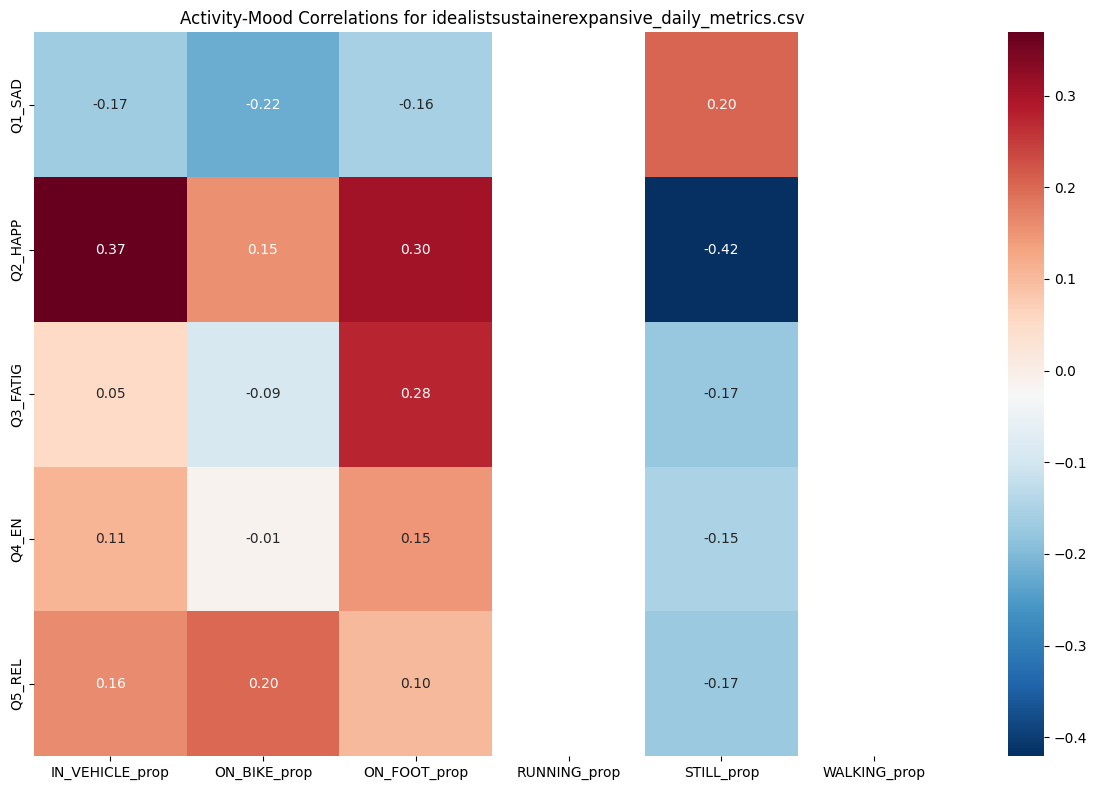

Processing ropetinworkdemote_daily_metrics.csv...

Activity Counts Summary:
       IN_VEHICLE     ON_BIKE     ON_FOOT  RUNNING        STILL  WALKING
count  242.000000  242.000000  242.000000    242.0   242.000000    242.0
mean     3.892562    0.136364    5.458678      0.0   121.842975      0.0
std      7.769289    0.570724    7.938061      0.0   237.148062      0.0
min      0.000000    0.000000    0.000000      0.0    15.000000      0.0
25%      0.000000    0.000000    0.000000      0.0    50.000000      0.0
50%      1.000000    0.000000    1.500000      0.0    60.000000      0.0
75%      4.000000    0.000000    8.750000      0.0    72.750000      0.0
max     56.000000    6.000000   44.000000      0.0  1385.000000      0.0

Mood Statistics:
           Q1_SAD     Q2_HAPP    Q3_FATIG       Q4_EN      Q5_REL
count  233.000000  233.000000  233.000000  233.000000  233.000000
mean     1.442625    2.614897    2.691985    1.899393    2.902472
std      0.610599    0.611919    0.758534    0.6534

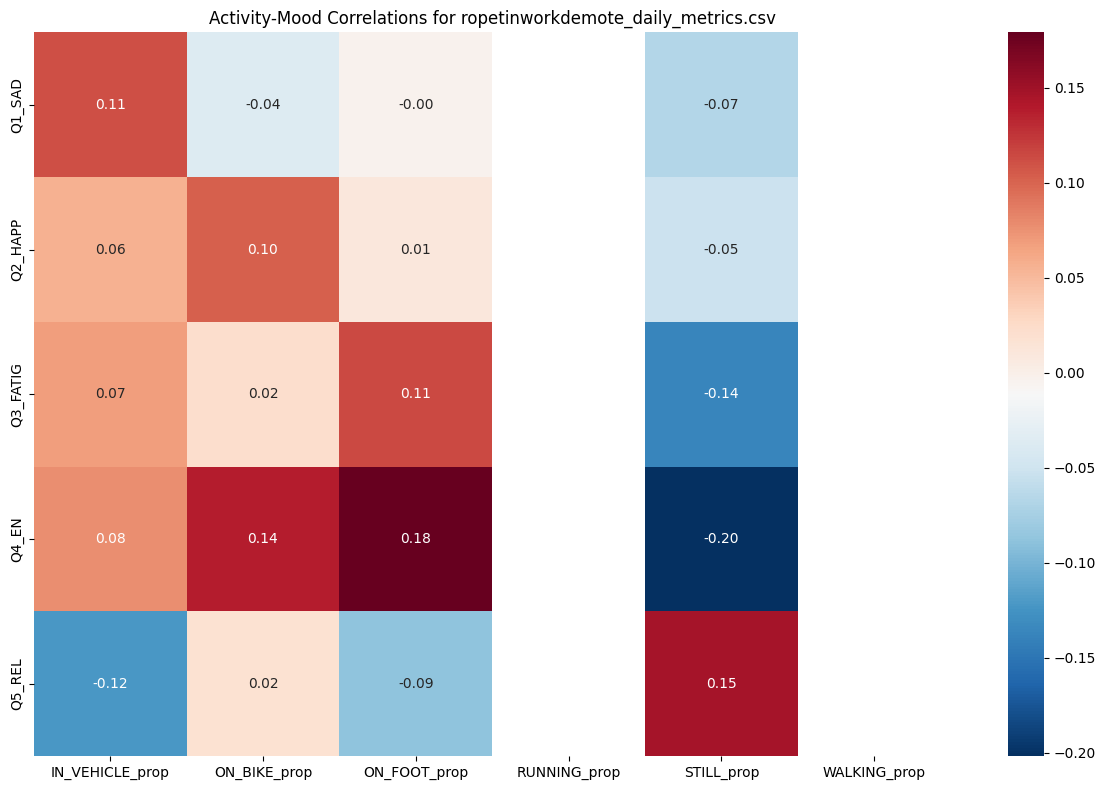

Processing slapstickporcupineslacks_daily_metrics.csv...


KeyError: "None of [Index(['IN_VEHICLE', 'ON_BIKE', 'ON_FOOT', 'RUNNING', 'STILL', 'WALKING'], dtype='object')] are in the [columns]"

In [11]:
subject_ids = sorted(os.listdir('data'))

results = {}

for subject_id in subject_ids:
    print(f'Processing {subject_id}...')

    # Load data
    df = pd.read_csv(f'data/{subject_id}')

    df['date'] = pd.to_datetime(df['date'])

    df['total_activities'] = df[activity_cols].sum(axis=1)

    for col in activity_cols:
        df[f'{col}_prop'] = df[col] / df['total_activities']
        
    if 'SCREEN_ON_SECONDS' in df.columns:
        df['daily_screen_hours'] = df['SCREEN_ON_SECONDS'] / 3600

    if 'UNLOCK_EVENTS_NUM' in df.columns and 'USAGE_DURATION_MIN' in df.columns:
        df['avg_session_duration'] = df['USAGE_DURATION_MIN'] / df['UNLOCK_EVENTS_NUM']
        df['usage_per_day_hours'] = df['USAGE_DURATION_MIN'] / 60

    df['dayofweek'] = df['date'].dt.weekday
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['month'] = df['date'].dt.month

    if 'MIMS_SUM_WEAR' in df.columns:
        # Create rolling statistics for physical activity
        df['activity_intensity'] = df['MIMS_SUM_WEAR']
        df['activity_intensity_ma7'] = df['MIMS_SUM_WEAR'].rolling(window=7).mean()
        df['activity_intensity_std7'] = df['MIMS_SUM_WEAR'].rolling(window=7).std()
    
    # Sleep features
    if 'SLEEP_MINUTES' in df.columns:
        df['sleep_hours'] = df['SLEEP_MINUTES'] / 60
        df['sleep_hours_ma7'] = df['sleep_hours'].rolling(window=7).mean()
    
    # Create lag features for mood variables
    mood_cols = ['Q1_SAD', 'Q2_HAPP', 'Q3_FATIG', 'Q4_EN', 'Q5_REL']
    for col in mood_cols:
        if col in df.columns:
            # Previous day
            df[f'{col}_lag1'] = df[col].shift(1)
            # Two days ago
            df[f'{col}_lag2'] = df[col].shift(2)
            # Weekly moving average
            df[f'{col}_ma7'] = df[col].rolling(window=7).mean()
            # Weekly standard deviation
            df[f'{col}_std7'] = df[col].rolling(window=7).std()


    print("\nActivity Counts Summary:")
    print(df[activity_cols].describe())
    
    # Mood patterns
    mood_cols = ['Q1_SAD', 'Q2_HAPP', 'Q3_FATIG', 'Q4_EN', 'Q5_REL']
    print("\nMood Statistics:")
    print(df[mood_cols].describe())
    
    # Correlations between activities and moods
    activity_props = [col for col in df.columns if '_prop' in col]
    correlations = df[mood_cols + activity_props].corr()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlations.loc[mood_cols, activity_props], 
                annot=True, fmt='.2f', cmap='RdBu_r')
    plt.title(f'Activity-Mood Correlations for {subject_id}')
    plt.tight_layout()
    plt.show()